In [1]:
!!pip install keras-cv
!!pip install pycocotools

# Imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_cv

from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Using TensorFlow backend


In [2]:
BATCH_SIZE =16

IMAGE_SIZE = (256, 256)

CLASSES = {
    0: "turtle",
    1: "penguin",
}

In [3]:
train_directory = "/kaggle/input/penguins-vs-turtles/train/train"
test_directory = "/kaggle/input/penguins-vs-turtles/valid/valid"

train_paths = sorted(os.path.join(train_directory, file) for file in os.listdir(train_directory))
test_paths =  sorted(os.path.join(test_directory, file) for file in os.listdir(test_directory))

In [4]:
def preprocess_annotations(path):
    df = pd.read_json(path)
    df["category_id"] = df["category_id"].replace(2, 0)
    return df

train_annotations = preprocess_annotations('../input/penguins-vs-turtles/train_annotations')
test_annotations = preprocess_annotations('../input/penguins-vs-turtles/valid_annotations')

train_annotations.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,0,"[225, 298, 198, 185]",36630,[],0
3,3,3,0,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


In [5]:
resizer = keras_cv.layers.Resizing(
    *IMAGE_SIZE, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

augmenter = keras.Sequential(
    layers=[
        resizer,
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    ]
)

In [6]:
from tensorflow.image import decode_jpeg, resize
from tensorflow.io import read_file
from tensorflow.data import Dataset, AUTOTUNE

def get_image(path, label, bbox):
    file = read_file(path)
    return decode_jpeg(file), label, bbox

def to_dict(image, label, bbox):
    # Convert to object detection format expected by Keras CV
    bounding_boxes = {
        "classes": [label],
        "boxes": [bbox],
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

def generate_dataset(image_paths, annotations, augment=False):
    return (
        Dataset.from_tensor_slices((
            image_paths,
            annotations["category_id"],
            annotations["bbox"].to_list())
        )
        .map(get_image, num_parallel_calls=AUTOTUNE)
        .map(to_dict, num_parallel_calls=AUTOTUNE)
        .ragged_batch(BATCH_SIZE)
        .map(lambda b: augmenter(b) if augment else resizer(b), num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

train_dataset = generate_dataset(train_paths, train_annotations, augment=True)
test_dataset = generate_dataset(test_paths, test_annotations)

print(train_dataset)
print(test_dataset)

<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, None]), tf.float32, 1, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>
<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>


In [7]:
from keras_cv.metrics import BoxCOCOMetrics
import tqdm

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch["images"], batch["bounding_boxes"]
            y_pred = self.model.predict(images, verbose=0)
            
            # Doesn't seem to work with ragged tensors :(
            y_pred = keras_cv.bounding_box.to_dense(y_pred, max_boxes=16)
            y_true = keras_cv.bounding_box.to_dense(y_true, max_boxes=16)

            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs


In [8]:
from keras.optimizers import SGD

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = keras_cv.models.RetinaNet(
        num_classes=len(CLASSES),
        bounding_box_format="xywh",
        backbone=keras_cv.models.ResNet50Backbone.from_preset(
            "resnet50_imagenet"
        )
    )
    
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
    
model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
)


Number of devices: 2
94657128/94657128 [==============================] - 1s 0us/step


In [9]:
EPOCHS = 20

# Train model

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[EvaluateCOCOMetricsCallback(test_dataset)]
)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 2.7414 - box_loss: 1.2708 - classification_loss: 1.4706 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:13<00:00,  2.60s/it]

32/32 [==============================] - 75s 727ms/step - loss: 2.7414 - box_loss: 1.2708 - classification_loss: 1.4706 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0679 - MaP@[IoU=50]: 0.3061 - MaP@[IoU=75]: 0.0050 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1448 - MaP@[area=large]: 0.0609 - Recall@[max_detections=1]: 0.1149 - Recall@[max_detections=10]: 0.1868 - Recall@[max_detections=100]: 0.1868 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1625 - Recall@[area=large]: 0.1950


Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 1.8261 - box_loss: 0.9710 - classification_loss: 0.8551 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

32/32 [==============================] - 13s 392ms/step - loss: 1.8261 - box_loss: 0.9710 - classification_loss: 0.8551 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0432 - MaP@[IoU=50]: 0.1669 - MaP@[IoU=75]: 0.0049 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0108 - MaP@[area=large]: 0.1277 - Recall@[max_detections=1]: 0.2174 - Recall@[max_detections=10]: 0.2679 - Recall@[max_detections=100]: 0.2760 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2045 - Recall@[area=large]: 0.3002


Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 1.4115 - box_loss: 0.7463 - classification_loss: 0.6652 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

32/32 [==============================] - 13s 394ms/step - loss: 1.4115 - box_loss: 0.7463 - classification_loss: 0.6652 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.1712 - MaP@[IoU=50]: 0.6090 - MaP@[IoU=75]: 0.0250 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0925 - MaP@[area=large]: 0.2395 - Recall@[max_detections=1]: 0.2876 - Recall@[max_detections=10]: 0.3046 - Recall@[max_detections=100]: 0.3061 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2028 - Recall@[area=large]: 0.3410


Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 1.2051 - box_loss: 0.6397 - classification_loss: 0.5654 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

32/32 [==============================] - 13s 394ms/step - loss: 1.2051 - box_loss: 0.6397 - classification_loss: 0.5654 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.1185 - MaP@[IoU=50]: 0.3803 - MaP@[IoU=75]: 0.0289 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0251 - MaP@[area=large]: 0.2420 - Recall@[max_detections=1]: 0.2923 - Recall@[max_detections=10]: 0.3273 - Recall@[max_detections=100]: 0.3318 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2389 - Recall@[area=large]: 0.3566


Epoch 5/20
32/32 [==============================] - ETA: 0s - loss: 1.0394 - box_loss: 0.5571 - classification_loss: 0.4823 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

32/32 [==============================] - 13s 402ms/step - loss: 1.0394 - box_loss: 0.5571 - classification_loss: 0.4823 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.1936 - MaP@[IoU=50]: 0.7088 - MaP@[IoU=75]: 0.0296 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1590 - MaP@[area=large]: 0.2379 - Recall@[max_detections=1]: 0.3162 - Recall@[max_detections=10]: 0.3273 - Recall@[max_detections=100]: 0.3273 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3056 - Recall@[area=large]: 0.3363


Epoch 6/20
32/32 [==============================] - ETA: 0s - loss: 0.9545 - box_loss: 0.5217 - classification_loss: 0.4328 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

32/32 [==============================] - 13s 387ms/step - loss: 0.9545 - box_loss: 0.5217 - classification_loss: 0.4328 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0213 - MaP@[IoU=50]: 0.0699 - MaP@[IoU=75]: 0.0080 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0071 - MaP@[area=large]: 0.2274 - Recall@[max_detections=1]: 0.3429 - Recall@[max_detections=10]: 0.3429 - Recall@[max_detections=100]: 0.3474 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2550 - Recall@[area=large]: 0.3852


Epoch 7/20
32/32 [==============================] - ETA: 0s - loss: 0.8437 - box_loss: 0.4632 - classification_loss: 0.3805 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

32/32 [==============================] - 13s 387ms/step - loss: 0.8437 - box_loss: 0.4632 - classification_loss: 0.3805 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0637 - MaP@[IoU=50]: 0.1876 - MaP@[IoU=75]: 0.0129 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0275 - MaP@[area=large]: 0.2848 - Recall@[max_detections=1]: 0.3971 - Recall@[max_detections=10]: 0.4225 - Recall@[max_detections=100]: 0.4225 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.5750 - Recall@[area=large]: 0.4094


Epoch 8/20
32/32 [==============================] - ETA: 0s - loss: 0.9005 - box_loss: 0.4578 - classification_loss: 0.4427 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

32/32 [==============================] - 13s 383ms/step - loss: 0.9005 - box_loss: 0.4578 - classification_loss: 0.4427 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0449 - MaP@[IoU=50]: 0.1304 - MaP@[IoU=75]: 0.0148 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0124 - MaP@[area=large]: 0.2632 - Recall@[max_detections=1]: 0.3518 - Recall@[max_detections=10]: 0.3576 - Recall@[max_detections=100]: 0.3591 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2683 - Recall@[area=large]: 0.3912


Epoch 9/20
32/32 [==============================] - ETA: 0s - loss: 0.6491 - box_loss: 0.3791 - classification_loss: 0.2701 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

32/32 [==============================] - 13s 390ms/step - loss: 0.6491 - box_loss: 0.3791 - classification_loss: 0.2701 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0470 - MaP@[IoU=50]: 0.1253 - MaP@[IoU=75]: 0.0165 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0203 - MaP@[area=large]: 0.1469 - Recall@[max_detections=1]: 0.3783 - Recall@[max_detections=10]: 0.4047 - Recall@[max_detections=100]: 0.4146 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3711 - Recall@[area=large]: 0.4313


Epoch 10/20
32/32 [==============================] - ETA: 0s - loss: 0.5606 - box_loss: 0.3381 - classification_loss: 0.2225 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

32/32 [==============================] - 13s 390ms/step - loss: 0.5606 - box_loss: 0.3381 - classification_loss: 0.2225 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0892 - MaP@[IoU=50]: 0.2462 - MaP@[IoU=75]: 0.0253 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0632 - MaP@[area=large]: 0.3501 - Recall@[max_detections=1]: 0.4471 - Recall@[max_detections=10]: 0.4471 - Recall@[max_detections=100]: 0.4528 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4400 - Recall@[area=large]: 0.4585


Epoch 11/20
32/32 [==============================] - ETA: 0s - loss: 0.4500 - box_loss: 0.2814 - classification_loss: 0.1686 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


32/32 [==============================] - 13s 396ms/step - loss: 0.4500 - box_loss: 0.2814 - classification_loss: 0.1686 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0752 - MaP@[IoU=50]: 0.2342 - MaP@[IoU=75]: 0.0252 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0493 - MaP@[area=large]: 0.2872 - Recall@[max_detections=1]: 0.3721 - Recall@[max_detections=10]: 0.3882 - Recall@[max_detections=100]: 0.3882 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4100 - Recall@[area=large]: 0.3792
Epoch 12/20
32/32 [==============================] - ETA: 0s - loss: 0.4370 - box_loss: 0.2767 - classification_loss: 0.1602 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]

32/32 [==============================] - 14s 430ms/step - loss: 0.4370 - box_loss: 0.2767 - classification_loss: 0.1602 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.1725 - MaP@[IoU=50]: 0.4334 - MaP@[IoU=75]: 0.1080 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1642 - MaP@[area=large]: 0.3205 - Recall@[max_detections=1]: 0.4352 - Recall@[max_detections=10]: 0.4352 - Recall@[max_detections=100]: 0.4408 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4491 - Recall@[area=large]: 0.4381


Epoch 13/20
32/32 [==============================] - ETA: 0s - loss: 0.3680 - box_loss: 0.2388 - classification_loss: 0.1292 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

32/32 [==============================] - 14s 409ms/step - loss: 0.3680 - box_loss: 0.2388 - classification_loss: 0.1292 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.3384 - MaP@[IoU=50]: 0.7082 - MaP@[IoU=75]: 0.3188 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3035 - MaP@[area=large]: 0.4512 - Recall@[max_detections=1]: 0.5014 - Recall@[max_detections=10]: 0.5014 - Recall@[max_detections=100]: 0.5100 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.5050 - Recall@[area=large]: 0.5146


Epoch 14/20
32/32 [==============================] - ETA: 0s - loss: 0.3675 - box_loss: 0.2440 - classification_loss: 0.1235 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

32/32 [==============================] - 13s 393ms/step - loss: 0.3675 - box_loss: 0.2440 - classification_loss: 0.1235 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.4235 - MaP@[IoU=50]: 0.9145 - MaP@[IoU=75]: 0.2683 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.4096 - MaP@[area=large]: 0.4375 - Recall@[max_detections=1]: 0.4842 - Recall@[max_detections=10]: 0.4842 - Recall@[max_detections=100]: 0.4842 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4750 - Recall@[area=large]: 0.4879


Epoch 15/20
32/32 [==============================] - ETA: 0s - loss: 0.3333 - box_loss: 0.2325 - classification_loss: 0.1008 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

32/32 [==============================] - 13s 377ms/step - loss: 0.3333 - box_loss: 0.2325 - classification_loss: 0.1008 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.3136 - MaP@[IoU=50]: 0.7304 - MaP@[IoU=75]: 0.1819 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2310 - MaP@[area=large]: 0.4211 - Recall@[max_detections=1]: 0.4508 - Recall@[max_detections=10]: 0.4636 - Recall@[max_detections=100]: 0.4636 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4250 - Recall@[area=large]: 0.4787


Epoch 16/20
32/32 [==============================] - ETA: 0s - loss: 0.3310 - box_loss: 0.2401 - classification_loss: 0.0910 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

32/32 [==============================] - 13s 391ms/step - loss: 0.3310 - box_loss: 0.2401 - classification_loss: 0.0910 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.2358 - MaP@[IoU=50]: 0.5964 - MaP@[IoU=75]: 0.0807 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1773 - MaP@[area=large]: 0.3688 - Recall@[max_detections=1]: 0.4000 - Recall@[max_detections=10]: 0.4088 - Recall@[max_detections=100]: 0.4147 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3850 - Recall@[area=large]: 0.4271


Epoch 17/20
32/32 [==============================] - ETA: 0s - loss: 0.3595 - box_loss: 0.2710 - classification_loss: 0.0884 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

32/32 [==============================] - 14s 425ms/step - loss: 0.3595 - box_loss: 0.2710 - classification_loss: 0.0884 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.0919 - MaP@[IoU=50]: 0.2620 - MaP@[IoU=75]: 0.0477 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0640 - MaP@[area=large]: 0.3305 - Recall@[max_detections=1]: 0.3401 - Recall@[max_detections=10]: 0.3479 - Recall@[max_detections=100]: 0.3527 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2750 - Recall@[area=large]: 0.3886


Epoch 18/20
32/32 [==============================] - ETA: 0s - loss: 0.3674 - box_loss: 0.2625 - classification_loss: 0.1048 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

32/32 [==============================] - 13s 398ms/step - loss: 0.3674 - box_loss: 0.2625 - classification_loss: 0.1048 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.1505 - MaP@[IoU=50]: 0.4026 - MaP@[IoU=75]: 0.0606 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1127 - MaP@[area=large]: 0.3665 - Recall@[max_detections=1]: 0.3808 - Recall@[max_detections=10]: 0.3926 - Recall@[max_detections=100]: 0.4043 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3383 - Recall@[area=large]: 0.4314


Epoch 19/20
32/32 [==============================] - ETA: 0s - loss: 0.3321 - box_loss: 0.2288 - classification_loss: 0.1034 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

32/32 [==============================] - 14s 407ms/step - loss: 0.3321 - box_loss: 0.2288 - classification_loss: 0.1034 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.2229 - MaP@[IoU=50]: 0.5178 - MaP@[IoU=75]: 0.1223 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2394 - MaP@[area=large]: 0.4143 - Recall@[max_detections=1]: 0.4757 - Recall@[max_detections=10]: 0.4771 - Recall@[max_detections=100]: 0.4843 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.5091 - Recall@[area=large]: 0.4729


Epoch 20/20
32/32 [==============================] - ETA: 0s - loss: 0.3118 - box_loss: 0.1941 - classification_loss: 0.1177 - percent_boxes_matched_with_anchor: 0.0000e+00

100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


32/32 [==============================] - 15s 424ms/step - loss: 0.3118 - box_loss: 0.1941 - classification_loss: 0.1177 - percent_boxes_matched_with_anchor: 0.0000e+00 - MaP: 0.2217 - MaP@[IoU=50]: 0.4673 - MaP@[IoU=75]: 0.1508 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2062 - MaP@[area=large]: 0.3540 - Recall@[max_detections=1]: 0.5179 - Recall@[max_detections=10]: 0.5192 - Recall@[max_detections=100]: 0.5192 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.5132 - Recall@[area=large]: 0.5234


<Axes: >

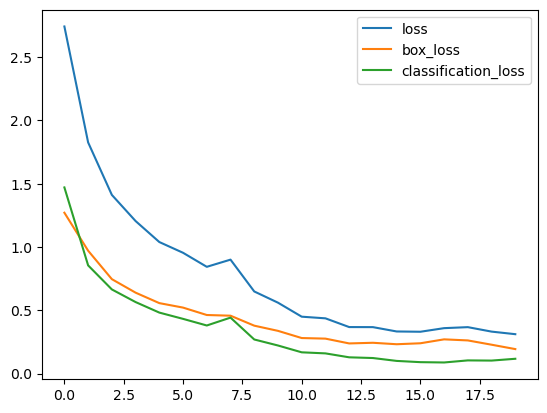

In [10]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'box_loss', 'classification_loss']].plot()

Use non-max supression to suppress overlapping bounding boxes 

In [11]:
from keras_cv import visualization

dataset_iter = iter(test_dataset)

1/1 [==============================] - 1s 741ms/step


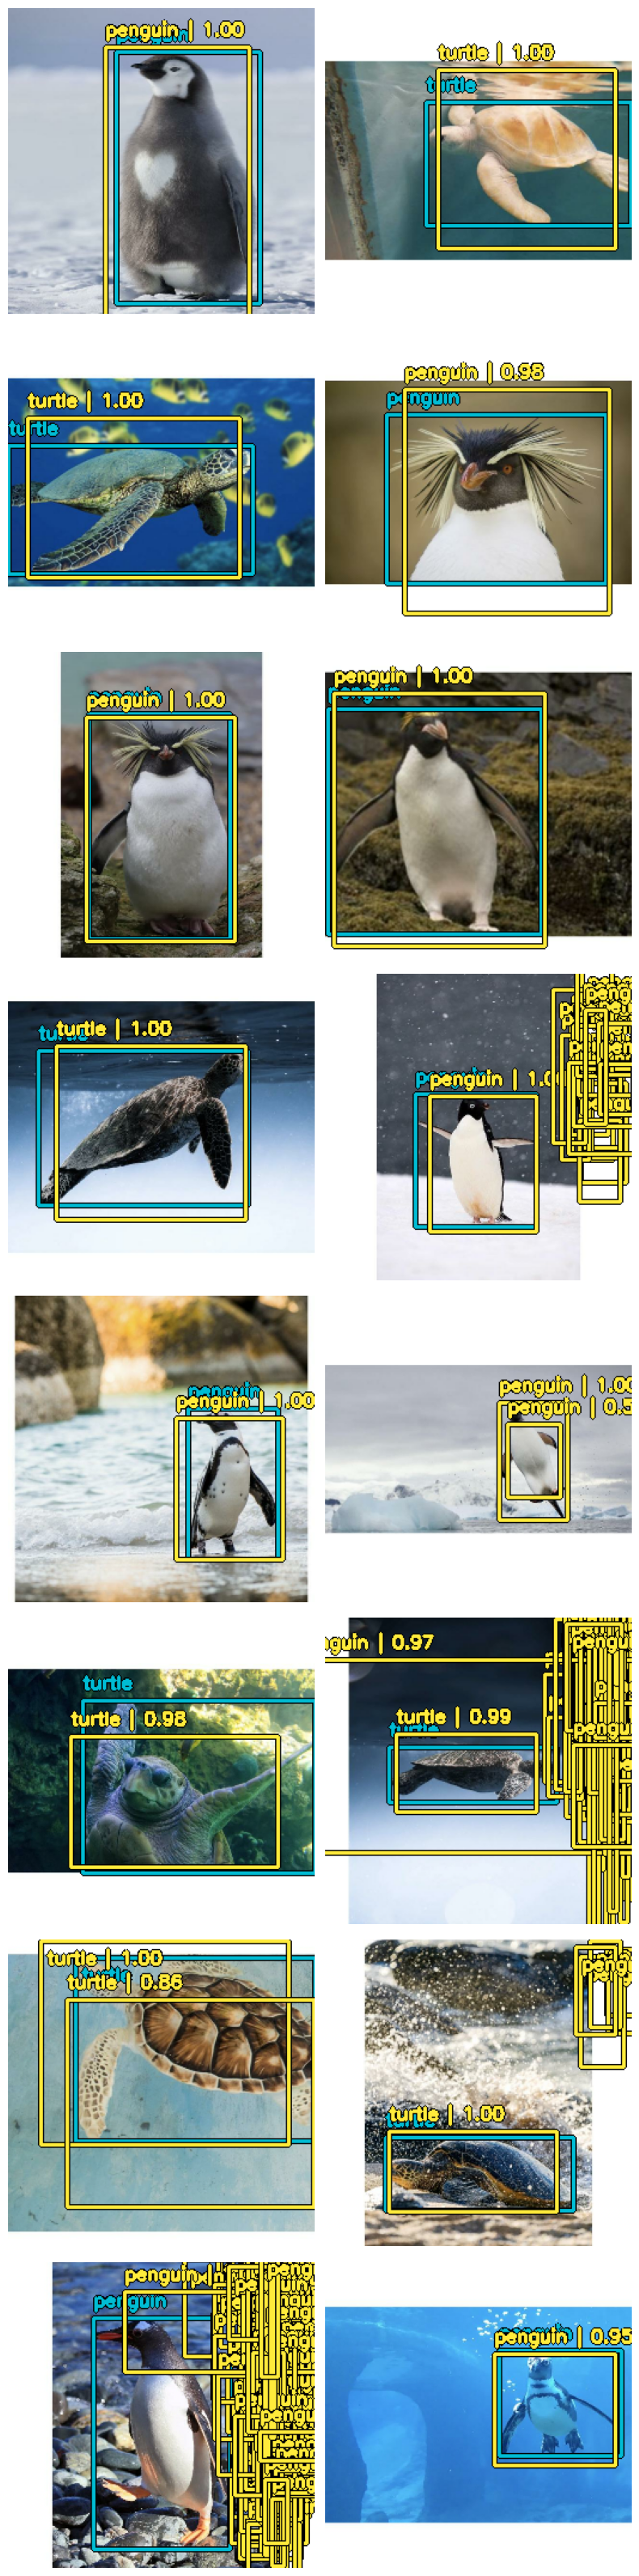

In [12]:
batch = next(dataset_iter)

prediction = model.predict(batch["images"])

# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    batch["images"],
    value_range=(0, 255),
    scale=4,
    cols=2,
    rows=BATCH_SIZE // 2,
    show=True,
    font_scale=0.5,
    y_pred=prediction,
    y_true=batch["bounding_boxes"],
    bounding_box_format="xywh",
    class_mapping=CLASSES,
)